# Tutorial 3: Unsupervised Classification

<ins>**Objectives:**</ins>

- **generate image embeddings**: you'll learn how to use a pre-trained CNN for
  generating image embeddings.

- **conduct image clustering**: you'll learn how to use image embeddings for
  clustering images into cohesive groups.

- **evaluate hyperparameters**: you'll learn how to evaluate the effect of some
  key hyperparameters on the output of you unsupervised image classification

<ins>**Datasets:**</ins>

- **protest dataset**: a dataset with sample images of street protests, related
  to BLM protests (and images that are not of protests), that also Nora and I
  put together.

<ins>**Key module/s:**</ins>

- **PyTorch**: there are many deep learning library/modules for python (e.g.
  keras, pytorch, tensorflow). I started using PyTorch a while back. Back then
  they made it very easy to e.g. use open-source pre-trained models and modify
  the architecture of those models. These days all these libraries have really
  good and similar functionalities. I'll stick to pytorch in these tutorials,
  but any of these libraries would do the trick.


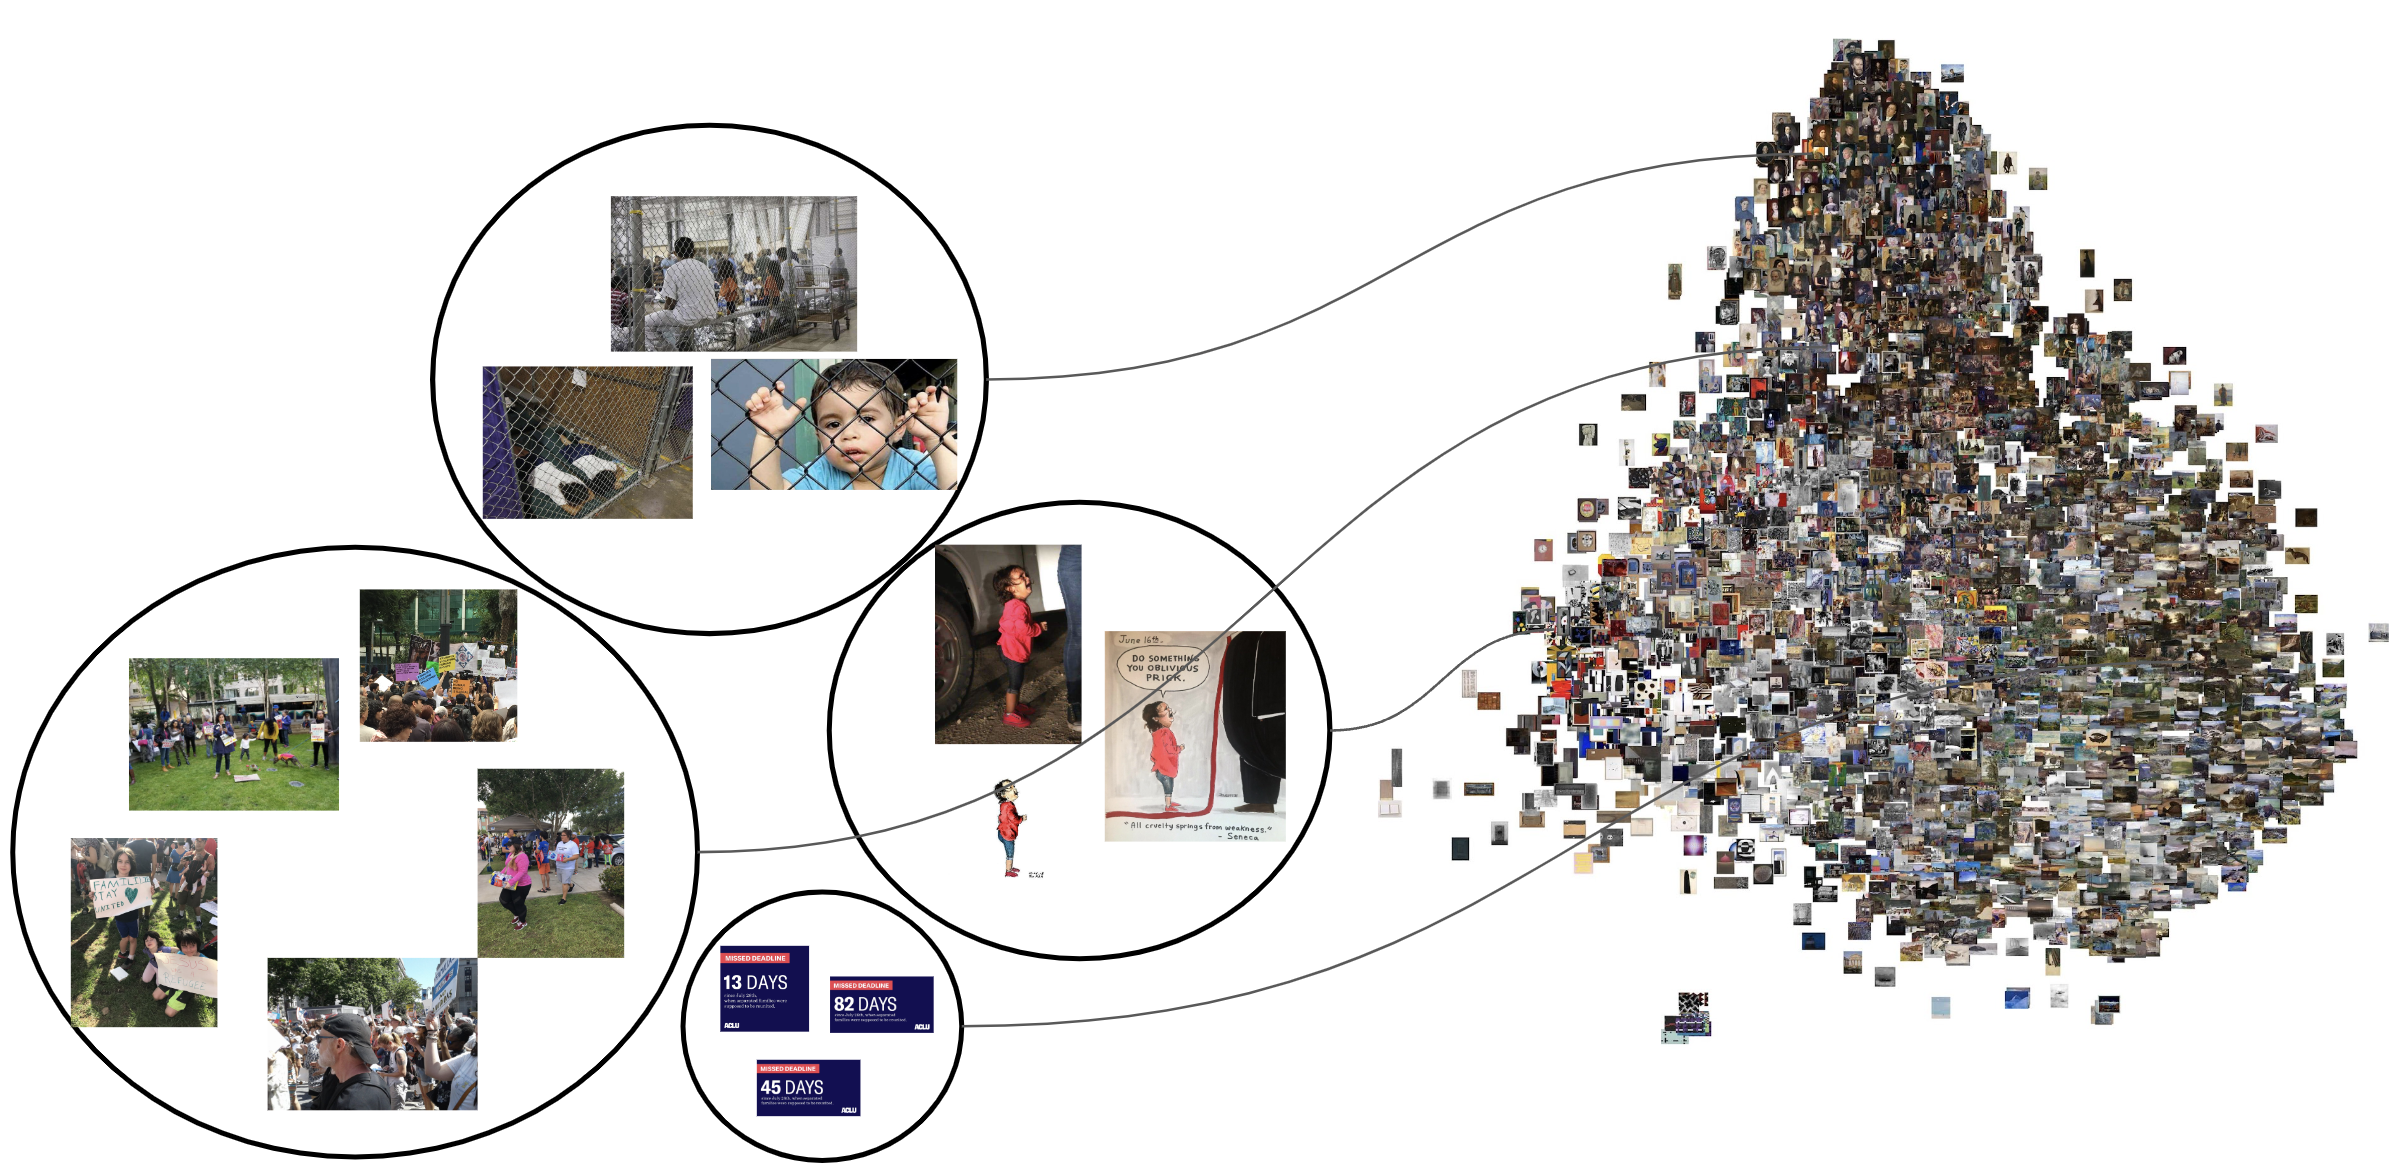


## 0. Install the packages/modules that we'll be using. Set up GPU.

These google-colab notebooks allow us to run code in virtual machines located
elsewhere. Every time we start a session, the virtual machine is "empty", so
non-native python modules need to be installed. Let's install the ones we'll
need in this particular notebook. We'll do so using `pip` and the `!` marker
that allows us to run `bash` code in the same notebook.


In [1]:
# - before getting started, set up GPU.
import tensorflow as tf

# - get the GPU device name.
device_name = tf.test.gpu_device_name()

# - the device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


## 1. Load the modules that we'll be using


In [3]:
from google.colab import drive # module to mount the google drive
import os
# - pytorch for deep learning modeling
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd
import seaborn as sns
import sys

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 2. Mount the Google Drive for the workshop to this virtual machine


In [4]:
# - it will generate a url. Click on it, specify the google account you want to
#   use, and
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 3. Declare the data path


In [5]:
data_path = '/content/'

## 4. Load a pre-trained model that we'll use for generating image embeddings

`PyTorch` make it very easy to load and use CNN models that have been trained on
huge datasets and perform very very well at predicting a specific set of
image-classes/objects (e.g. car, truck, chair, horse, person, etc.). Let's first
learn how to load these pre-trained models using pytorch, and then we'll use one
of these models (ResNet50) to generate image embeddings[link text](https://)


In [6]:
# - load two pre-trained image models: Resnet50 and MnasNet
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# - set up the model to "evaluation" mode: so to avoid the model for training
#   further and the weights to be updated. We only want to generate predictions.
model.eval()

# - use GPU if available
if torch.cuda.is_available():
    model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
# - take a look at the model architecture
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 5. Drop the last fully-connected layer of the model

This way we can easily pass images through the model, and get the output of the
second-to-last layer. These outputs are dense vector representation of the
images (embeddings), and will be very useful for identifying similar images and
clustering them together


In [8]:
embed_gen = nn.Sequential(*list(model.children())[:-1])

## 6. Data to be clustered

We'll use the **protest dataset** used in the supervised classification
tutorial. Let's create a list of paths to all the images, so that we can easily
work with them


In [9]:
# - initialize empty list
imgpaths = []
# - iterate through the 'protest' data folder, and pull the path to the train/test
#   and postitive/negative ones.
protest_path = '{}protest/'.format(data_path)
protest_subdirs = [x for x in os.listdir(protest_path) if '.DS_Store' not in x]
for subdir in protest_subdirs:
  protest_subsubdirs = [x for x in os.listdir('{}{}'.format(protest_path, subdir))
                        if '.DS_Store' not in x]
  for subsubdir in protest_subsubdirs:
    imgfiles = os.listdir('{}{}/{}'.format(protest_path, subdir, subsubdir))
    imgfiles02 = ['{}{}/{}/{}'.format(protest_path, subdir, subsubdir, x)
                  for x in imgfiles if '.jpg' in x]
    imgpaths.extend(imgfiles02)

In [10]:
len(imgpaths)

200

In [11]:
imgpaths.sort()

In [12]:
imgpaths[:4]

['/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/test/negative/1477.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/test/negative/28559.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/test/negative/29986.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/test/negative/3019.jpg']

## 7. Using pre-trained model for generating image embeddings

Now let's used the version of the pre-trained ResNet50 model, for which we've
dropped the last fully-connected layer, to generate image embeddings, by passing
the images trough the model and pulling the vector representation outputed by
that second-to-last layer of the model.

The resulting embeddings will be of size 2048


In [13]:
# - a function to preprocess an image file so it fits the input requirements of
#   the pretrained models.
#   This function already does the cropping and resizing for you. It also makes
#   sure that the color distribution follows that of the data used for training
#   the original model
def data_transform(train = True, mean = [0.485, 0.456, 0.406],
                  sd = [0.229, 0.224, 0.225],
                  scale = 256, random_crop = 224):
    """
    Description: This function creates an object to transform train and
        test (or only testing) images.
    Parameters:
        `train`: type <bool> indicating if the object will need to be used
                    to transform training and testing images (=True) or
                    only testing.
        `mean`: type <list> of 3 floats indicating the mean value of the 3 RGB
                    image inputs.
        `sd`: type <list> of 3 floats indicating the standard deviation of
                    the 3 RGB mean inputs.
        `scale`: type <int> indicating the new size to give to the train and
                    test data (e.g. 256x256 pixel images).
        `random_crop`: type <int> indicating the size of the part of the image
                    really used for training-testing (e.g. 224x224)
    Output:
        An object to be used for preprocessing the train and test images
    Example:
        preprocess = data_transform()
    """
    if train:
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(scale),
                transforms.RandomResizedCrop(random_crop),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
            'test': transforms.Compose([
                transforms.Resize(scale),
                transforms.CenterCrop(random_crop),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
        }
    else:
        data_transforms = transforms.Compose([
            transforms.Resize(scale),
            transforms.CenterCrop(random_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, sd)
        ])
    return(data_transforms)

In [14]:
# - initialize an empty list where we'll be placing the output embeddings
embed_out = []

# - create a preprocessing object
resnet_preprocess = data_transform(train = False)

# - iterate through the images and generate the two different embeddings
for ipath in tqdm(imgpaths):
  img = Image.open(ipath).convert('RGB')
  img_transformed = Variable(resnet_preprocess(img).unsqueeze(0))
  img_vect_raw = embed_gen(img_transformed.cuda()).data.cpu()
  img_vect = [float(x[0][0]) for x in list(img_vect_raw[0])]
  embed_out.append(img_vect)

100%|██████████| 200/200 [01:44<00:00,  1.92it/s]


## 8. Clustering

- First, we'll create a single matrix with all the image embeddings (200 x 2048)
- Then, we'll use a Kmeans clustering algorithm to cluster the images
- We'll try out different numbers of clusters; and assess which number of
  clusters best fits the data


In [15]:
# - list of embeddings into a single matrix
embed_mat = np.array(embed_out)

In [16]:
# - let's take a quick look at the shape of this matrix: 200 (images) X 2048 (size of the embedding)
embed_mat.shape

(200, 2048)

In [17]:
# - here how the embedding representation of the first image looks like
embed_out[0]

[0.0,
 0.0,
 0.3649885654449463,
 1.623378038406372,
 0.6253528594970703,
 0.008407079614698887,
 0.0,
 0.13855452835559845,
 0.0,
 0.0,
 0.18950700759887695,
 0.0,
 0.15344226360321045,
 0.032707951962947845,
 0.0,
 0.004171059932559729,
 0.027446167543530464,
 0.0,
 0.0,
 0.1855001151561737,
 0.0,
 0.0,
 0.0,
 0.027605032548308372,
 0.0,
 0.007311514113098383,
 0.013481366448104382,
 0.0,
 0.0005246966611593962,
 0.00828119833022356,
 0.04268115386366844,
 0.12896457314491272,
 0.021770233288407326,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.26474061608314514,
 0.04402732104063034,
 0.009702336974442005,
 0.08728603273630142,
 0.0,
 0.011599691584706306,
 0.0,
 0.00952456146478653,
 0.0,
 0.0,
 0.0,
 0.03507569432258606,
 0.0,
 0.45308807492256165,
 0.0,
 0.021809367462992668,
 0.0,
 0.0,
 0.021092258393764496,
 0.0,
 0.019485151395201683,
 0.0017347383545711637,
 0.07279042899608612,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.23837867379188538,
 0.0,
 0.0,
 0.0,
 0.005128646269440651,
 0.20466473

In [18]:
# - now let's cluster these image embeddings, every time using a different number
#   of clusters. This is one of the key hyperamaters to take into consideration
k_options = range(2, 60, 2) # any possible even value between 2 and 60,
gof_scores = pd.DataFrame() # an empty data frame where we'll store information about goodnes of fit for each clustering option
counter = 0
for k in tqdm(k_options):
  km = KMeans(n_clusters = k)
  km.fit(embed_mat)
  k_gof = km.score(embed_mat)
  gof_newrow = pd.DataFrame({
      'k':k,
      'gof':k_gof
  }, index = [counter])
  gof_scores = pd.concat((gof_scores, gof_newrow))
  counter += 1

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/29 [00:00<00:04,  5.89it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/29 [00:00<00:05,  5.34it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 3/29 [00:00<00:05,  4.79it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

In [19]:
gof_scores.head()

k           gof
0   2 -32284.130929
1   4 -27679.755865
2   6 -25709.261974
3   8 -24670.934785
4  10 -23812.280599

<Axes: xlabel='k', ylabel='gof'>

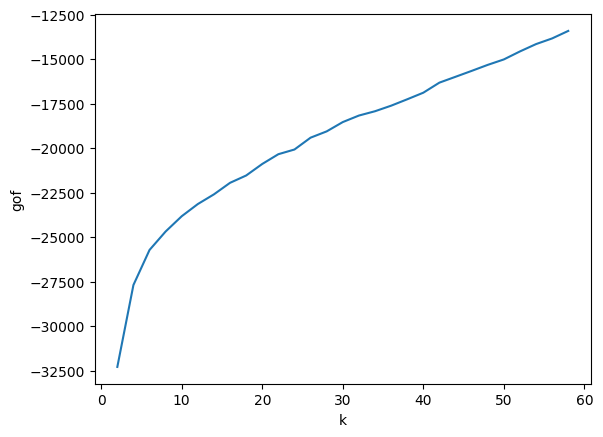

In [20]:
# - plot the goodness of fit measure against the number of clusters (k parameter)
sns.lineplot(data=gof_scores, x="k", y="gof")

In [21]:
# - around 10-20 cluster the increment in terms of goodness of fit only seems to
#   be marginal. To avoid overfitting, let's move forward with e.g. 14 clusters
# - let's then fit this final clustering model with 14 clusters
km = KMeans(n_clusters = 14, random_state = 1234) # set a random seed for replicability purposes
km.fit(embed_mat)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=14, random_state=1234)

In [22]:
# - now let's pull the cluster assignment for each of the 200 images, and store
#   the information in dataframe where we also have information about the path
#   to each image
cl_out = pd.DataFrame({
    'image_path':imgpaths,
    'cluster':km.labels_
})

In [23]:
# - let's quickly explore how this dataframe looks like
cl_out.head()

image_path  cluster
0  /content/gdrive/MyDrive/images-as-data-worksho...        7
1  /content/gdrive/MyDrive/images-as-data-worksho...        0
2  /content/gdrive/MyDrive/images-as-data-worksho...        8
3  /content/gdrive/MyDrive/images-as-data-worksho...        0
4  /content/gdrive/MyDrive/images-as-data-worksho...        9

## 9. Explore the resulting clusters

- Take a look at the clusters


In [24]:
# - a function that helps merge images together into a single image, so that
#   we can visualize a set of images together
def show_combined_images(path_list):
  """
  path_list: a list of paths to the image files to be combined into a single one
  """
  images = [Image.open(x) for x in path_list]
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_img = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_img.paste(im, (x_offset,0))
    x_offset += im.size[0]

  return(new_img)

In [25]:
# - take a quick look at the cluster size distribution
cl_out.groupby(['cluster']).size().reset_index().rename(
    columns = {0:'n'}).sort_values('n', ascending = False)

cluster   n
10       10  32
3         3  25
7         7  24
12       12  18
11       11  15
5         5  13
0         0  12
9         9  12
13       13  11
2         2  10
4         4   9
6         6   9
8         8   8
1         1   2

In [28]:
# - sample e.g. 5 images from cluster 0
sample5_cl00 = list(cl_out[cl_out['cluster'] == 0].sample(5)['image_path'])

In [29]:
sample5_cl00

['/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/train/negative/33299.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/train/negative/19289.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/train/negative/162.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/train/negative/4972.jpg',
 '/content/gdrive/MyDrive/images-as-data-workshop-gesis/data/protest/test/negative/4259.jpg']

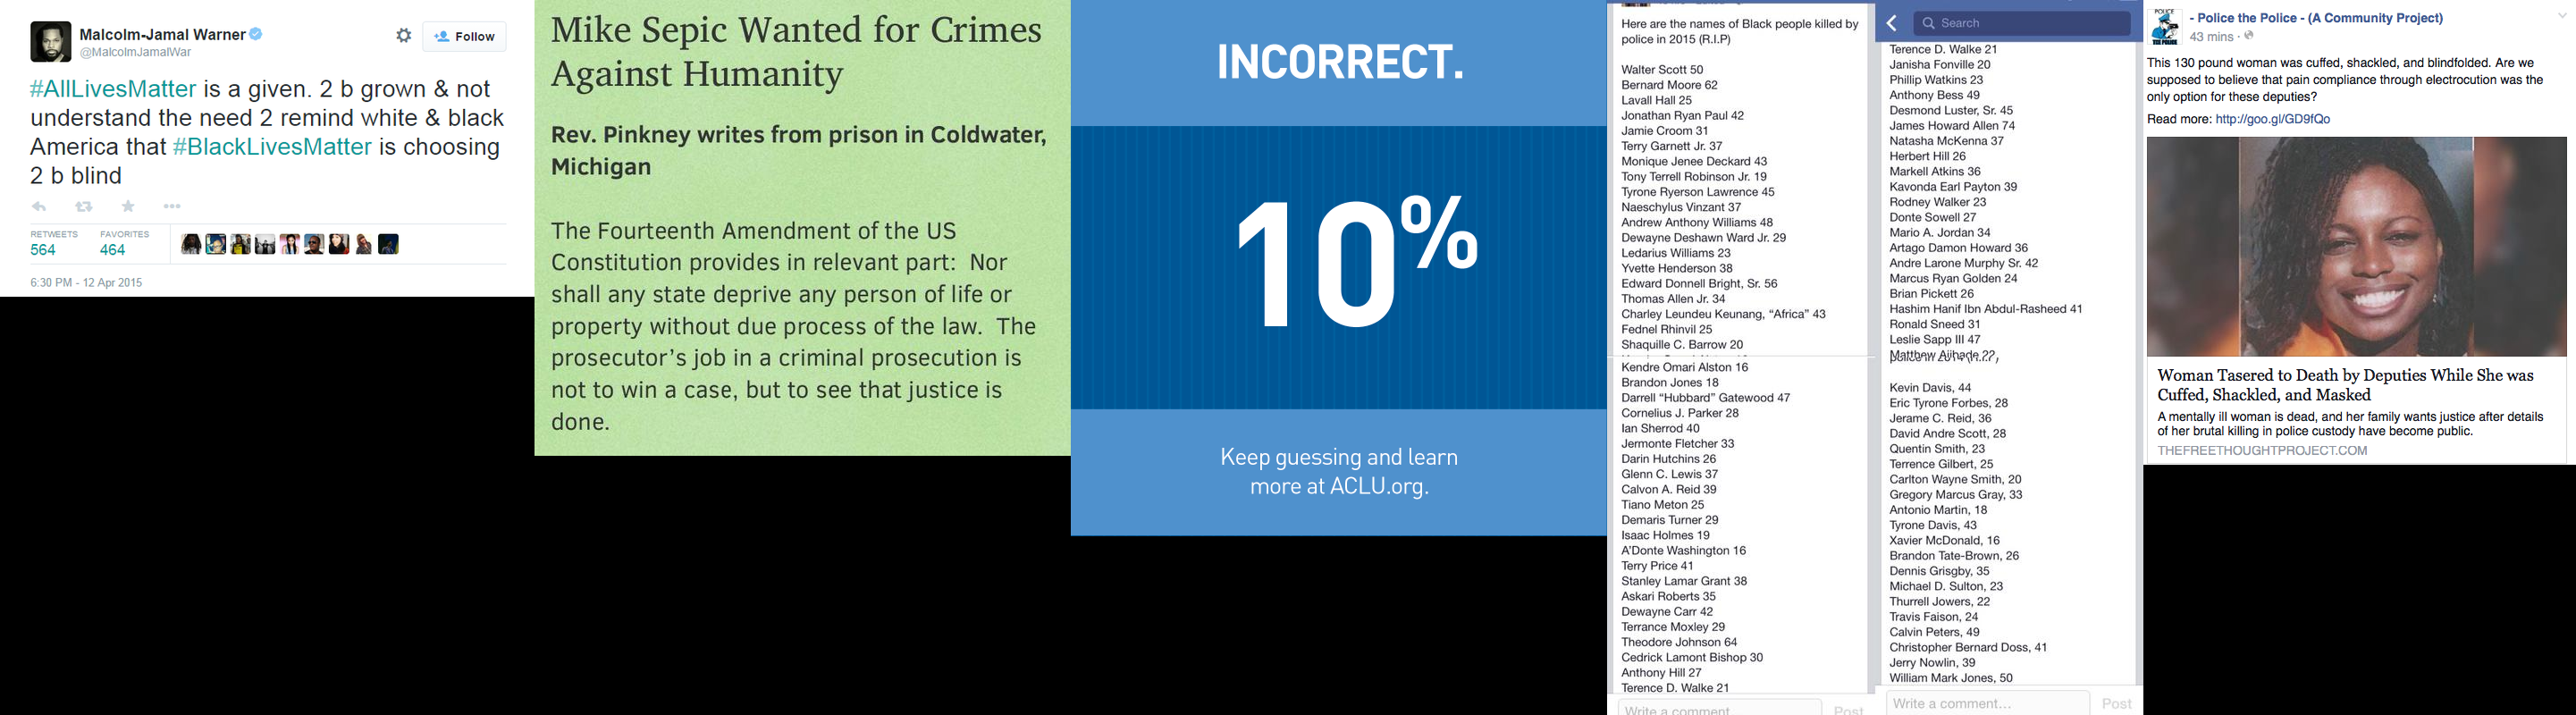

In [31]:
show_combined_images(sample5_cl00)

In [32]:
# - let's take a look at some images from the cluster 4
sample5_cl04 = list(cl_out[cl_out['cluster'] == 4].sample(5)['image_path'])
show_combined_images(sample5_cl04)

Output hidden; open in https://colab.research.google.com to view.

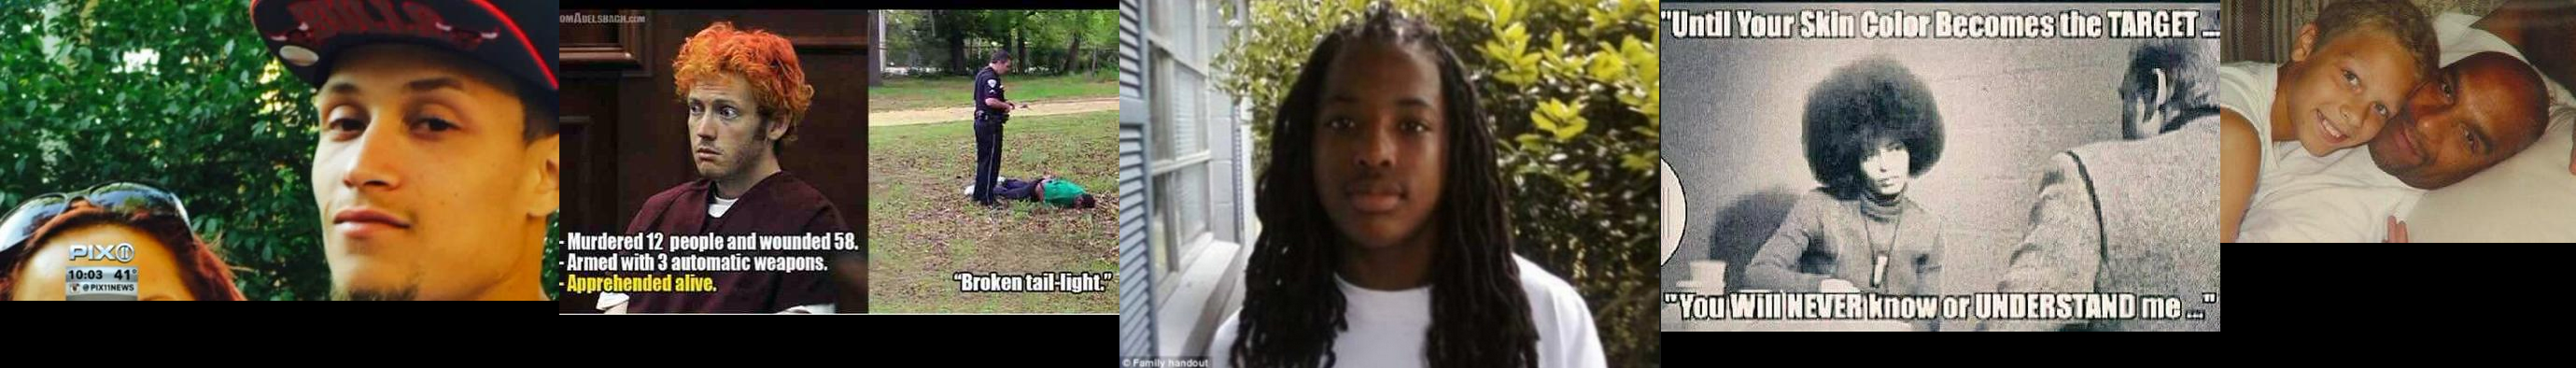

In [33]:
# - let's do the same for cluster  a look at some images from the cluster 9 & 13
sample5_cl09 = list(cl_out[cl_out['cluster'] == 9].sample(5)['image_path'])
show_combined_images(sample5_cl09)

In [35]:
sample5_cl3 = list(cl_out[cl_out['cluster'] == 13].sample(5)['image_path'])
show_combined_images(sample5_cl3)

Output hidden; open in https://colab.research.google.com to view.

In [48]:
# - some of the resulting clusters are more "cohesive" than others. the silhouette
#   scores can help us identify less cohesive clusters (e.g. for further
#   clustering). We can get silhouette scores for each image (provides
#   information about how that image is similar to other images in that cluster,
#   and dissimilar to images in other clusters). I ranges from -1 to 1, where 1
#   means very high within-cluster similarity, and very low across-cluster
#   similarity.
cl_out['sil_score'] = silhouette_samples(embed_mat, km.labels_)

In [49]:
cl_out.head()

image_path  cluster  sil_score
82   /content/gdrive/MyDrive/images-as-data-worksho...        7  -0.025325
190  /content/gdrive/MyDrive/images-as-data-worksho...        2   0.045482
16   /content/gdrive/MyDrive/images-as-data-worksho...       11   0.040049
124  /content/gdrive/MyDrive/images-as-data-worksho...       10   0.127101
127  /content/gdrive/MyDrive/images-as-data-worksho...       10   0.000778

In [50]:
cl_out.groupby(['cluster']).mean().sort_values('sil_score')

<ipython-input-50-7835c21edfe7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cl_out.groupby(['cluster']).mean().sort_values('sil_score')


sil_score
cluster           
8         0.002662
5         0.024289
9         0.025334
3         0.033638
4         0.050059
13        0.052244
7         0.054557
6         0.057255
2         0.072518
12        0.078496
10        0.085943
1         0.090861
0         0.099965
11        0.110880

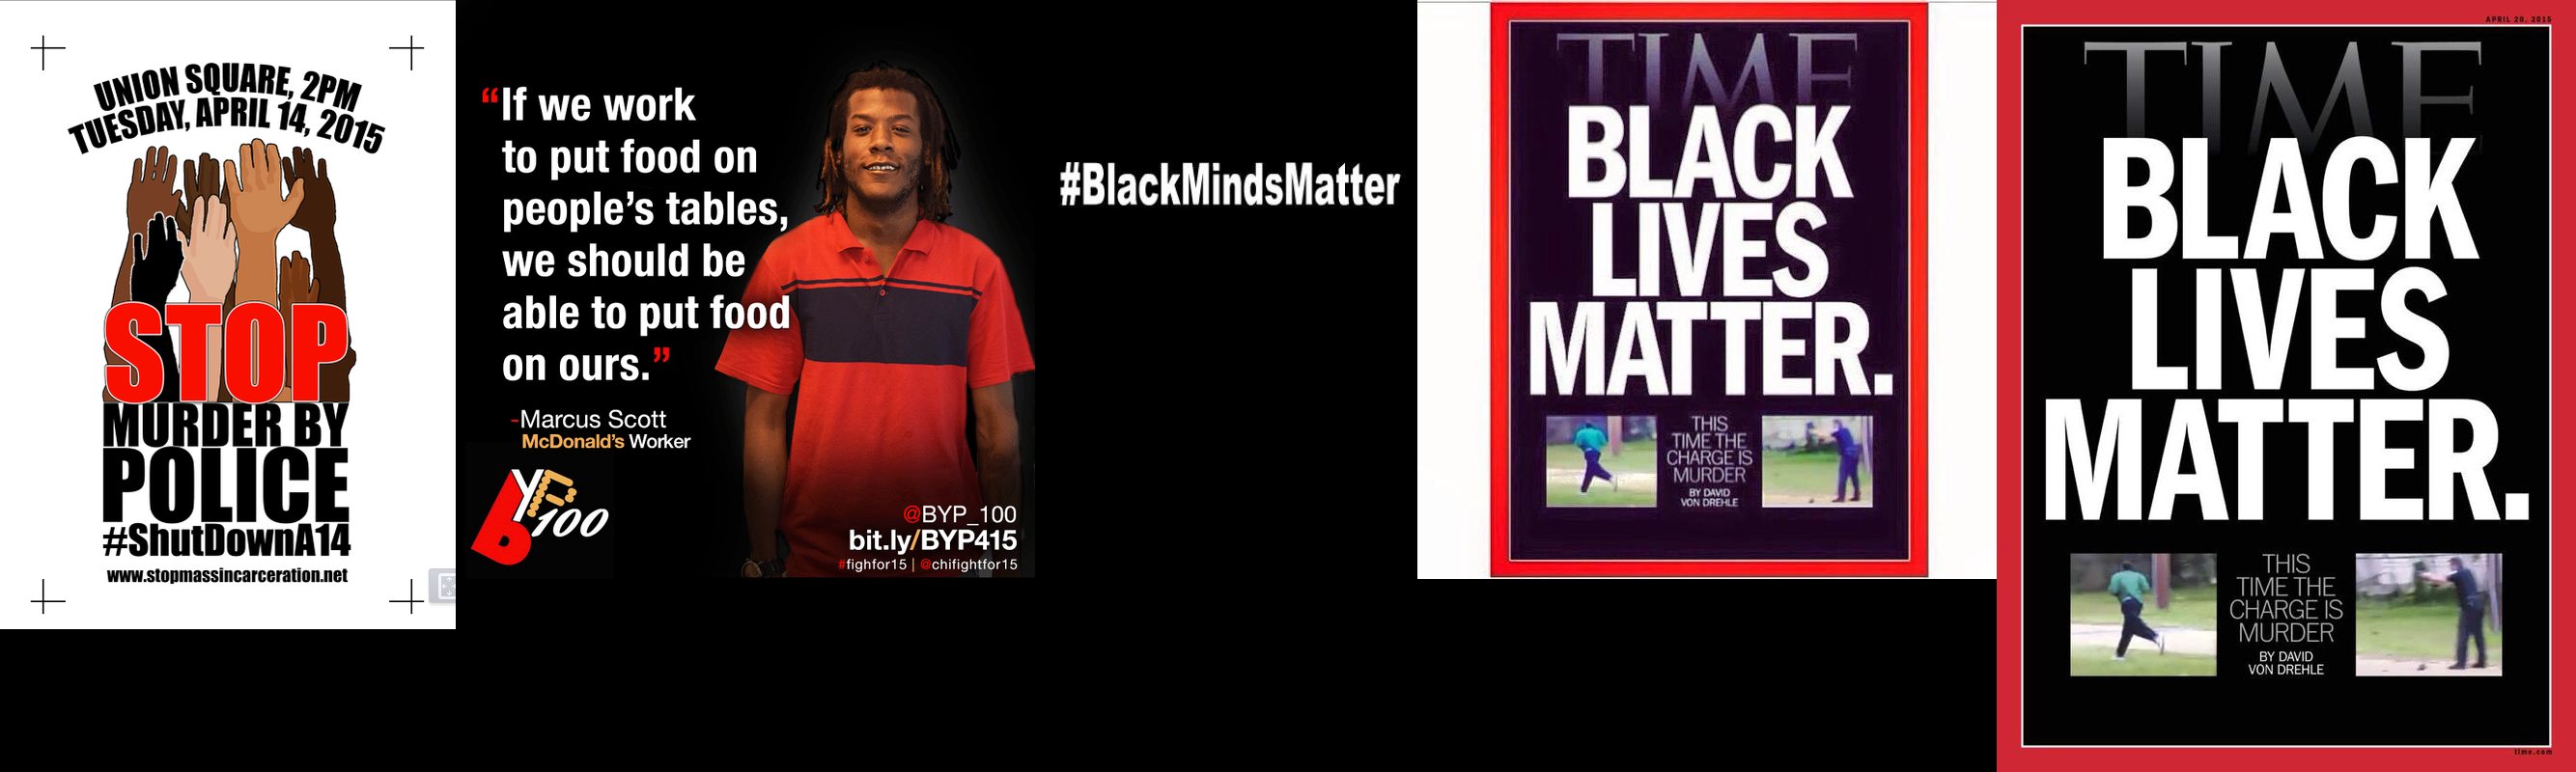

In [46]:
# - cluster 8 seems to be the least cohesive (see examples above)
# - clusters 0 and 11 seem to be the most cohesive, let's take a look
sample5_cl08 = list(cl_out[cl_out['cluster'] == 8].sample(5)['image_path'])
show_combined_images(sample5_cl08)

In [47]:
sample5_cl11 = list(cl_out[cl_out['cluster'] == 11].sample(5)['image_path'])
show_combined_images(sample5_cl11)

Output hidden; open in https://colab.research.google.com to view.